In [ ]:
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn.client import Client
import matplotlib.pyplot as plt
client = Client("IRIS")

### Accessing Station Matadata -- [`client.get_stations`](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_stations.html)


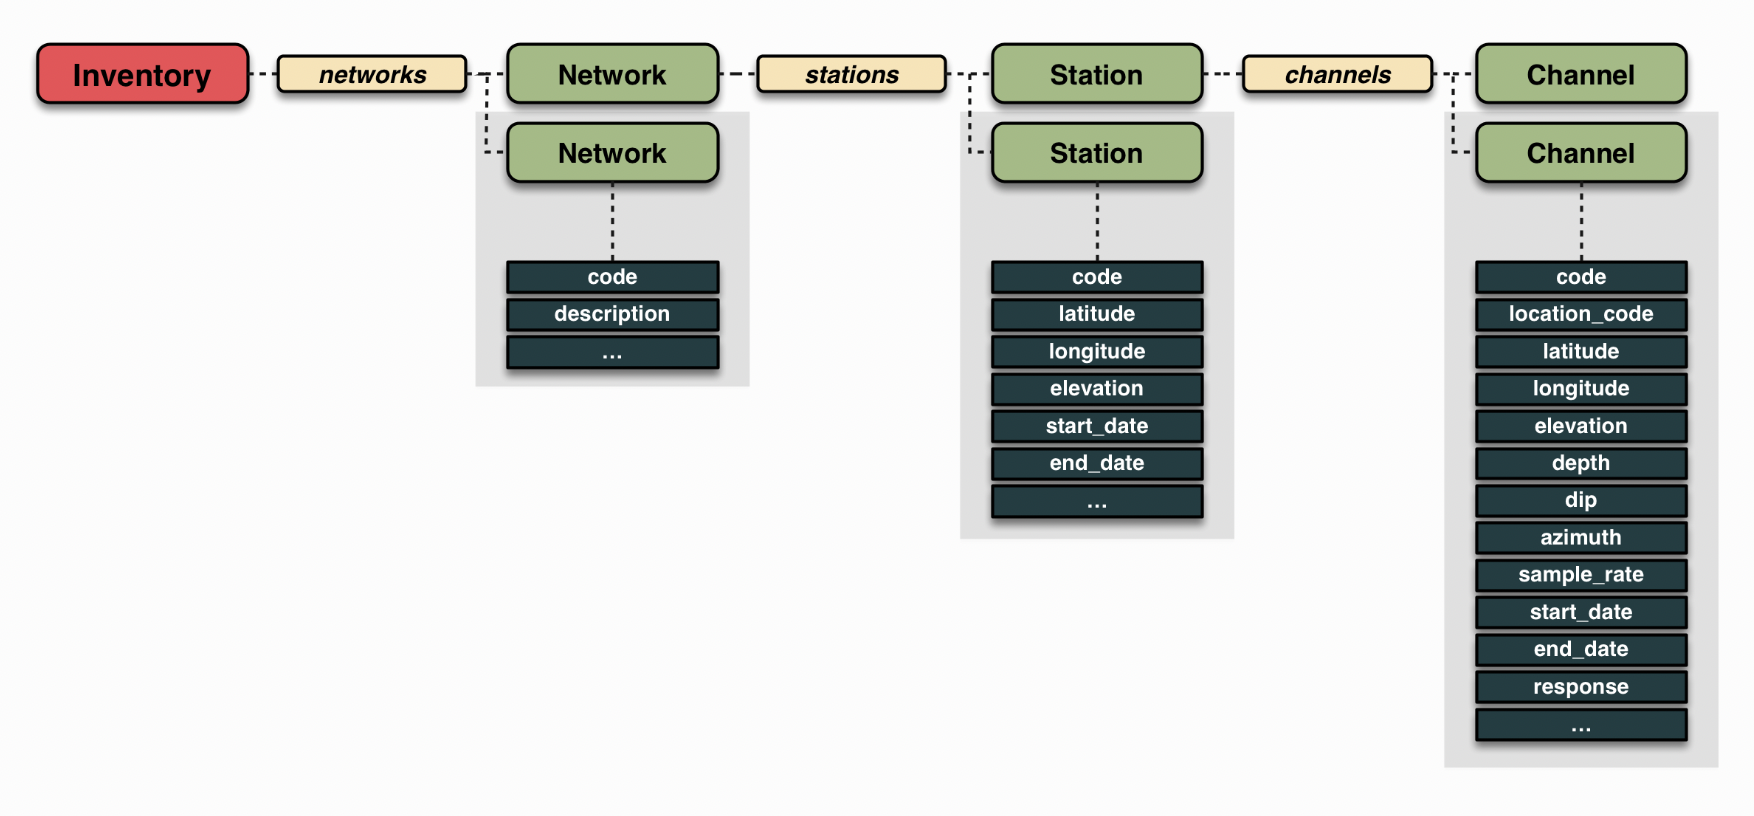

Network: [TW](https://ds.iris.edu/mda/TW/)

In [ ]:
starttime = UTCDateTime("2022-01-01")
endtime = UTCDateTime("2024-12-31")
inventory = client.get_stations(network="TW", station="*",
                                starttime=starttime,
                                endtime=endtime)

What is the difference between `inventory`, `inventory[0]`, and `inventory[0][0]` ?


In [ ]:
inventory

In [ ]:
inventory[0]

In [ ]:
inventory[0][0]

### Essential information for seismic stations

In [ ]:
for sta in inventory[0]:
    STA = sta.code
    lon = sta.longitude
    lat = sta.latitude
    ele = sta.elevation
    print(STA, lon, lat, ele)

## Accessing Event MetaData -- [`client.get_events`](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_events.html)
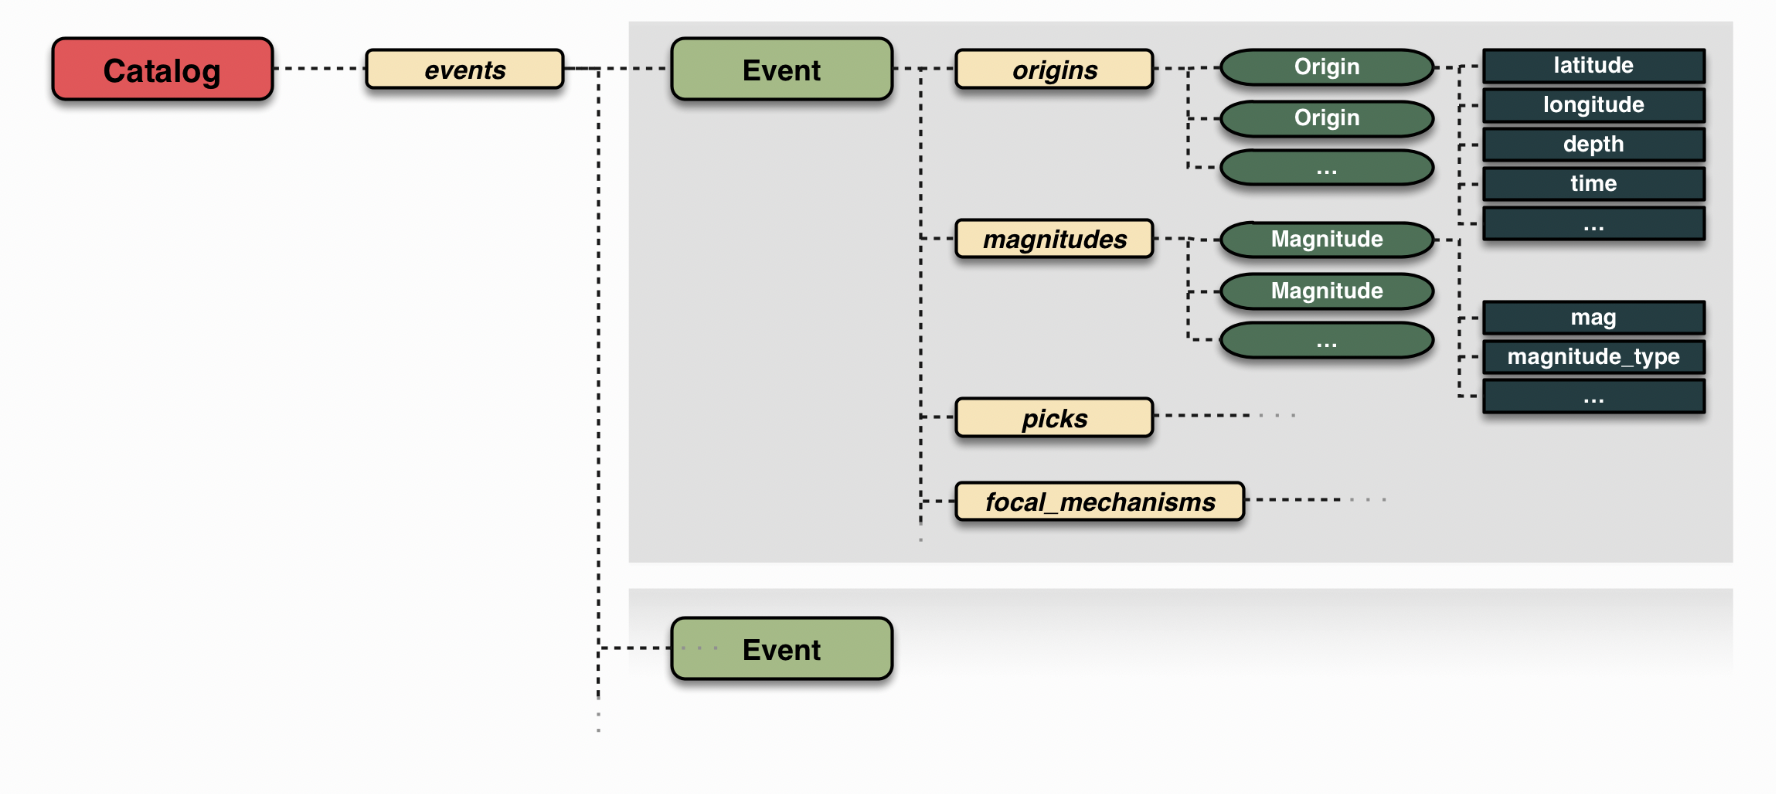

In [ ]:
client = Client("IRIS")
cata = client.get_events(
        starttime = UTCDateTime(2024, 1, 1),
        endtime = UTCDateTime(2025, 1, 1,), 
        latitude = 24.9754, 
        longitude = 121.4881,
        maxradius = 20,
        minmagnitude = 6,
        orderby = 'time')

### Three major elements of earthquakes: time, location, magnitude

In [ ]:
for cat in cata:
    time = cat.origins[0].time
    lon = cat.origins[0].longitude
    lat = cat.origins[0].latitude
    dep = cat.origins[0].depth/1000
    mag = cat.magnitudes[0].mag
    print(time, lon, lat, dep, mag)
    

## Access waveform -- [`client.get_waveforms`](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html)
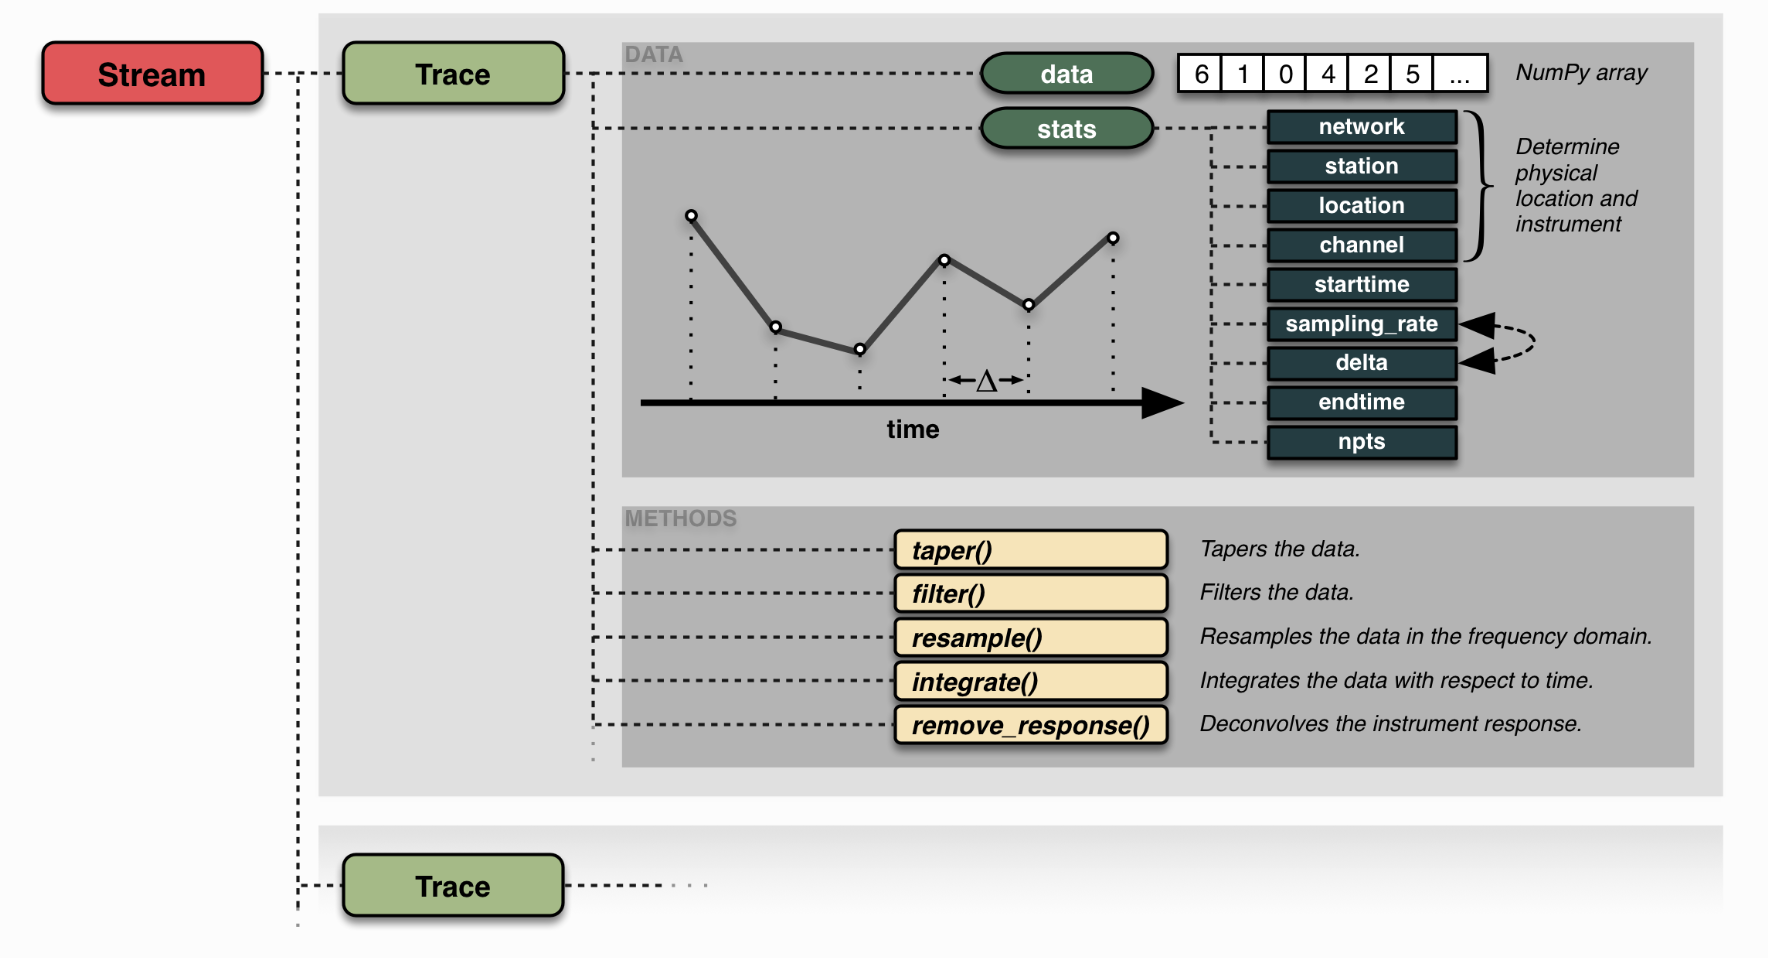

The seismic wave is a convolution of the source, the instrument response, and Earth's structure.

In [ ]:
idx = 5
time = cata[idx].origins[0].time
network = 'TW'
station = 'TWGB'
stlat = 22.817699
stlon = 121.079903 

st = client.get_waveforms(network, station, "*", "BH*",
                          time, time + 10 * 60, attach_response=True)


In [ ]:
st

In [ ]:
st.plot(show=False)

In [ ]:
st_copy = st.copy()
st_copy.remove_response(pre_filt=[0.004, 0.005, 9, 10], output="VEL")
st_copy.detrend('linear')
st_copy.detrend('demean')

In [ ]:
st_copy.plot(show=False)

In [ ]:
plt.figure(figsize=(6,4))

TIME = st_copy[0].times()
trE = st_copy.select(component='E')[0]
trN = st_copy.select(component='N')[0]
trZ = st_copy.select(component='Z')[0]
norm = max(max(trE.data),max(trN.data), max(trZ.data))
plt.plot(TIME, trE.data/norm, 'k', lw=1)
plt.plot(TIME, trN.data/norm+2, 'k', lw=1)
plt.plot(TIME, trZ.data/norm+4, 'k', lw=1)

plt.yticks(ticks=[0,1,2,3,4,], labels=['BHE', '', 'BHN','', 'BHZ'])
plt.xlim(TIME[0], TIME[-1])
plt.xlabel(f'Time from origin (s)')

lat = cata[idx].origins[0].latitude
lon = cata[idx].origins[0].longitude
dep = cata[idx].origins[0].depth/1000
mag = cata[idx].magnitudes[0].mag
title = f'TW.{station} | {time}\n {lat}°N {lon}°E Depth: {round(dep,2)} km Mag: {mag} Deg: {round(deg,2)}°'
plt.title(title)

In [ ]:
from obspy.geodetics.base import gps2dist_azimuth, kilometers2degrees

- **Great circle distance** is the distance between two points on a sphere

- **Azimuth** to which the output coordinate system will be aligned. It is typically chosen to be the direction from a seismic source to the seismic station measured clockwise from north.

- **Backazimuth** is typically in the direction from the seismic station towards a seismic source. It is 180° off from the azimuth.


[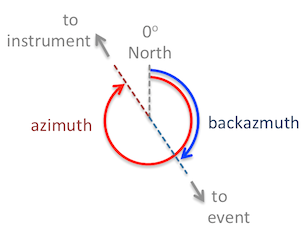](https://service.iris.edu/irisws/rotation/docs/1/help/)
[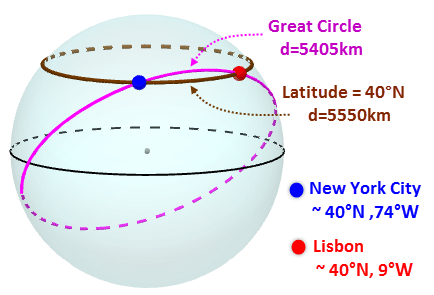](https://aviation.stackexchange.com/questions/92619/can-a-great-circle-be-drawn-between-any-two-points-on-earth)

In [ ]:
dist, az, baz = gps2dist_azimuth(cata[idx].origins[0].latitude, #source lat
                                 cata[idx].origins[0].longitude, # source lon
                                 stlat,  # station lat
                                 stlon)  # station lon
print(dist, az, baz)
deg = kilometers2degrees(dist/1000)

print(deg)

## Travel time -- [`model.get_travel_times`](https://docs.obspy.org/packages/autogen/obspy.taup.tau.TauPyModel.get_travel_times.html)

[Time vs. distance graph of seismic waves](https://www.iris.edu/hq/inclass/animation/traveltime_curves_how_they_are_created)


In [ ]:
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")

In [ ]:
arrivals = model.get_travel_times(source_depth_in_km=cata[idx].origins[0].depth/1000,
                                  distance_in_degree=deg,
                                  phase_list=['P', 'S', '3.8kmps'])

print(arrivals)

In [ ]:
print(arrivals[0].time)

In [ ]:
plt.figure(figsize=(6,4))

plt.vlines(x=arrivals[0].time, ymin=-1, ymax=5, color='red', ls='--', lw=1)
plt.vlines(x=arrivals[5].time, ymin=-1, ymax=5, color='blue', ls='--', lw=1)
plt.vlines(x=arrivals[8].time, ymin=-1, ymax=5, color='green', ls='--', lw=1)

TIME = st_copy[0].times()
trE = st_copy.select(component='E')[0]
trN = st_copy.select(component='N')[0]
trZ = st_copy.select(component='Z')[0]
norm = max(max(trE.data),max(trN.data), max(trZ.data))
plt.plot(TIME, trE.data/norm, 'k', lw=1)
plt.plot(TIME, trN.data/norm+2, 'k', lw=1)
plt.plot(TIME, trZ.data/norm+4, 'k', lw=1)


plt.yticks(ticks=[0,1,2,3,4,], labels=['BHE', '', 'BHN','', 'BHZ'])
plt.xlim(TIME[0], TIME[-1])
plt.xlabel(f'Time from origin (s)')
plt.title(title, fontsize=11)

## Rotation -- [`stream.rotate`](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.rotate.html)
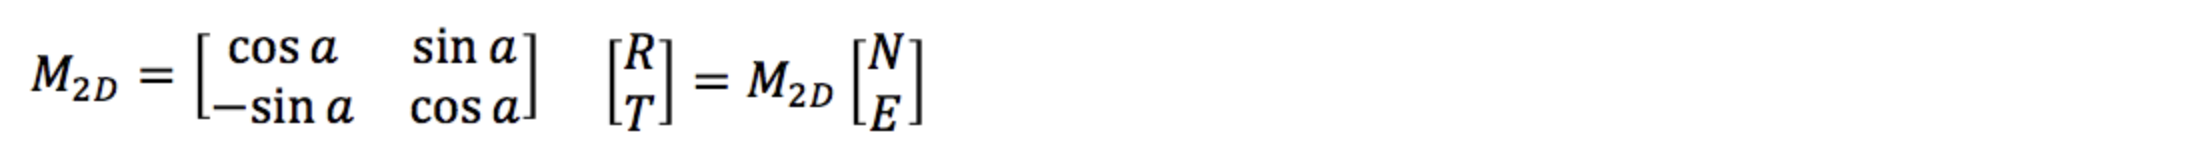

- **N** and **E** represent data from the original (horizontal) orientations
- **R** and **T** represent the Radial and Transverse components.
- **α** is the azimuth measured clockwise from north

[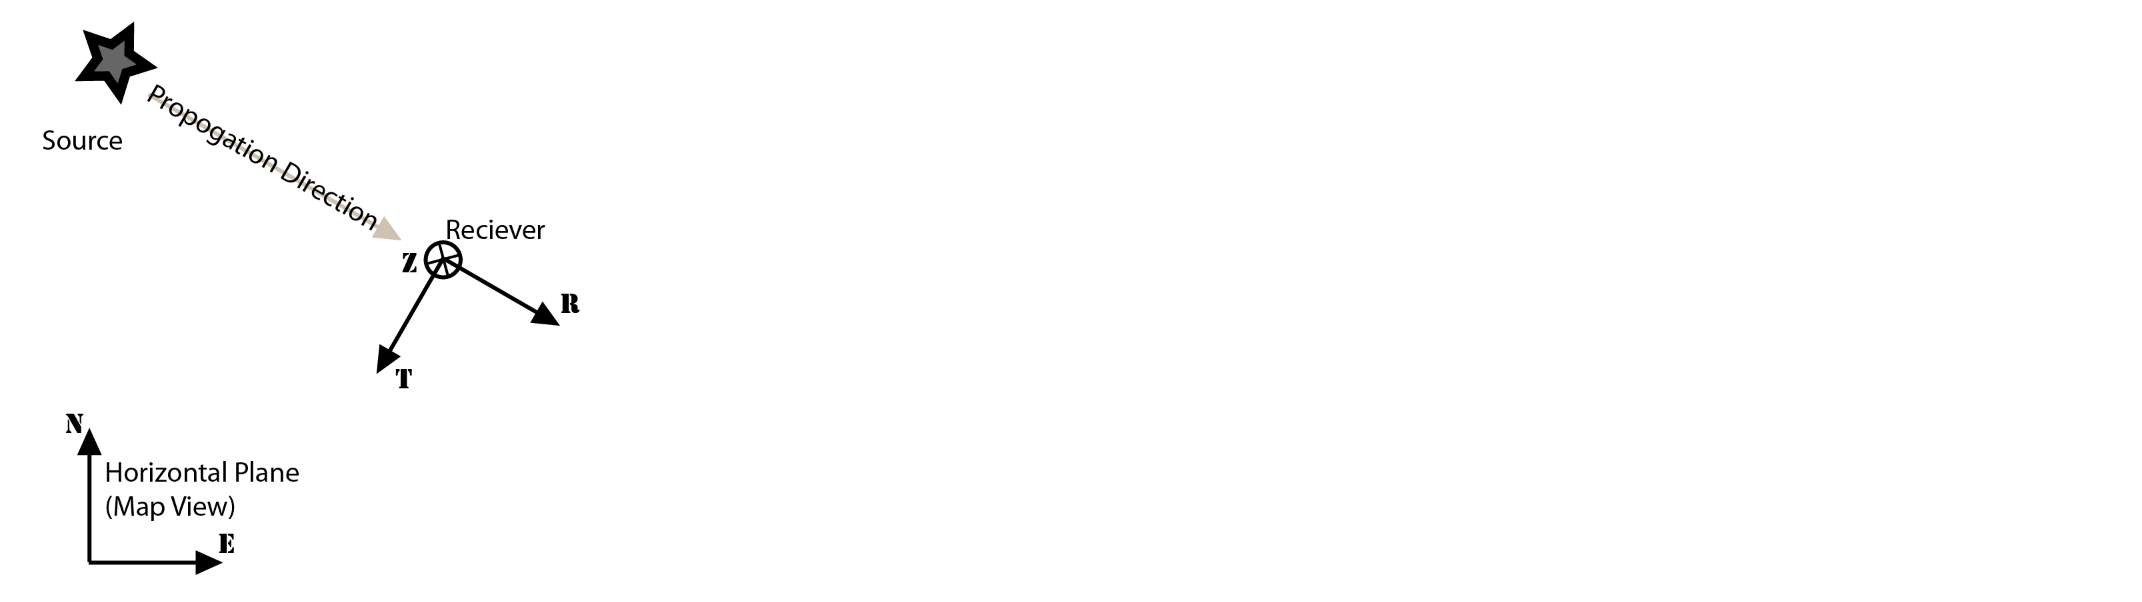](https://service.iris.edu/irisws/rotation/docs/1/help/)

In [ ]:
st_ZRT = st_copy.copy()
st_ZRT.rotate(method='NE->RT', back_azimuth=baz)

In [ ]:
plt.figure(figsize=(6,4))

plt.vlines(x=arrivals[0].time, ymin=-1, ymax=5, color='red', ls='--', lw=1)
plt.vlines(x=arrivals[5].time, ymin=-1, ymax=5, color='blue', ls='--', lw=1)
plt.vlines(x=arrivals[8].time, ymin=-1, ymax=5, color='green', ls='--', lw=1)

TIME = st_ZRT[0].times()
trT = st_ZRT.select(component='T')[0]
trR = st_ZRT.select(component='R')[0]
trZ = st_ZRT.select(component='Z')[0]
norm = max(max(trT.data),max(trR.data), max(trZ.data))

plt.plot(TIME, trT.data/norm, 'k', lw=1)
plt.plot(TIME, trR.data/norm+2, 'k', lw=1)
plt.plot(TIME, trZ.data/norm+4, 'k', lw=1)


plt.yticks(ticks=[0,1,2,3,4,], labels=['BHT', '', 'BHR','', 'BHZ'])
plt.xlim(st_copy[0].times()[0], st_copy[0].times()[-1])
plt.xlabel(f'Time from origin (s)')
plt.title(title, fontsize=11)